# PROJET VELIB - MDI 230
##### Mona Mokart, Lola Vitrac et Zakary Saheb


## Importation et données

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

On définit d'abord notre base de données à partir de l'excel : 

In [ ]:
tau = np.array([[0, 3, 5, 7, 7],
                [2, 0, 2, 5, 5], 
                [4, 2, 0, 3, 3], 
                [8, 6, 4, 0, 2], 
                [7, 7, 5, 2, 0]])*60  # on convertit ces temps en seconde comme demandé dans l'énoncé

lambda_ = np.array([2.8, 3.7, 5.5, 3.5, 4.6])/3600

p = np.array([[0, 0.22, 0.32, 0.2, 0.26],
              [0.17, 0, 0.34, 0.21, 0.28], 
              [0.19, 0.26, 0, 0.24, 0.31],
              [0.17, 0.22, 0.33, 0, 0.28], 
              [0.18, 0.24, 0.35, 0.23, 0]])

n_stations = np.array([20, 15, 17, 13, 18])

n_trajets = np.array([[0, 1, 0, 0, 0],
                      [1, 0, 1, 0, 0], 
                      [0, 1, 0, 1, 0], 
                      [0, 0, 1, 0, 1], 
                      [0, 0, 0, 1, 0]])

lambda_st = np.zeros((5,5))  # matrices des lambdas des stations vers les trajets 
lambda_ts = np.zeros((5,5))  # matrices des lambdas des trajets vers les stations

for i in range (5):
  for j in range (5): 
    if i != j :
      lambda_st[i][j]= lambda_[i]*p[i][j]
      lambda_ts[i][j]= 1/tau[i,j]
    else : 
      lambda_st[i][j]=0
      lambda_ts[i][j]=0

## Modélisation

**3. Nous allons simuler les trajectoires du processus de Markow.**

In [ ]:
def delta_t(lambda_st,lambda_ts,E): #
  """calcule la durée avant un changement en fonction des lambdas et des etats"""
  lambda_tot = 0 
  for i in range (E.shape[0]):
    for j in range (E.shape[1]):
      if i!=j :  
        lambda_tot += lambda_st[i][j]*(E[i][i]>0) + lambda_ts[i][j]*E[i][j]  # somme des taux car le temps correspond au min lois exponentielles
  delta_min= np.random.exponential(1/lambda_tot)  # choisit un temps selon la loi expo(lambda_tot)
  return(delta_min, lambda_tot)

def choose_path(E,lambda_tot): 
  """cette fonction renvoie 1 en 1er élément si part d'une station
  sinon renvoie 0 si le vélo arrive sur une station"""
  random = np.random.rand()
  cum = 0
  for j in range (E.shape[0]):
    for i in range (E.shape[1]):
      if i!=j:
        cum += lambda_st[i][j]*(E[i][i]>0)
        if cum/lambda_tot > random :    # proba de transition cumulé
          return 1,i,j
        cum+=lambda_ts[i][j]*(E[i][j])
        if cum/lambda_tot > random : 
          return 0,i,j  

def simulation(deadline,n_stations,n_trajets,lambda_st,lambda_ts): 
  """deadline la durée approximative de la simulation"""
  E= n_trajets + np.diag(n_stations) #l'ensemble des états
  nb_station=[list(n_stations)] #liste de listes, nombre de vélo dans chaque station à un instant donné
  times=[0]
  time=0
  while time<deadline:
    delta_min, lambda_tot= delta_t(lambda_st, lambda_ts,E)  # on calcule le temps avant le prochain evenement
    time+=delta_min
    times.append(time)
    id, i, j= choose_path(E, lambda_tot)  # on choisit la transition selon les probas
    if id == 1 :  # départ d'une station
      E[i][i]-=1
      E[i][j]+=1
    else :        # arrivée dans une station
      E[i][j]-=1
      E[j][j]+=1
    nb_station.append(list(np.diag(E)))
  nb_station = np.array(nb_station)
  return (E,times,nb_station)

def trace(times,nb_station):
  plt.figure(figsize=(20,13))
  plt.clf()
  for i in range (5) :
    plt.plot(times, nb_station[:,i], label="Nombre de vélos en station {}".format(i+1))
  plt.xlabel("Temps (s)")
  plt.ylabel("Nombre de vélos")
  plt.title("Simulation des trajectoires")
  plt.legend()
  plt.plot()

[[27  0  0  0  0]
 [ 0 18  0  0  0]
 [ 0  0 14  0  0]
 [ 0  0  0 20  0]
 [ 0  1  0  1 10]]


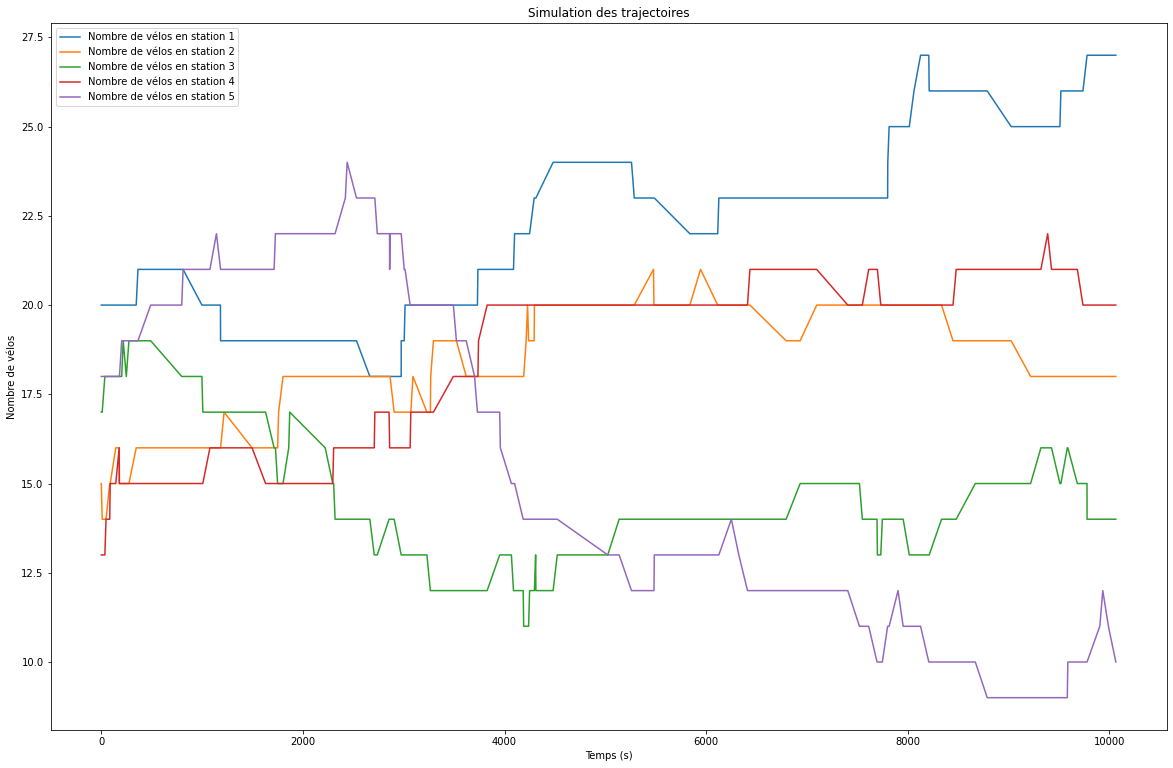

In [ ]:
E,times,nb_station = simulation(10000,n_stations,n_trajets,lambda_st,lambda_ts)
print(E)
trace(times,nb_station)

**4. Nous devons maintenant en déduire la probabilité que chaque station soit vide après 150
heures.** En utilisant la question précédente, on réalise 100 fois cette simulation sur 150h et on en déduit le pourcentage de fois où chacune des 5 stations à été égale à zéro.

Soit X la variable aléatoire de Bernouilli qui vaut 1 quand la station est vide et 0 sinon. Alors on peut appliquer la partie 7.3 du pdf de consigne sur les intervalles de confiance avec $\theta = E(X) = P(X=1)$

In [ ]:
def perc_vide(deadline, n_stations, n_trajets, lambda_st, lambda_ts, iter=100):
  vides = np.zeros(5)
  for i in range (iter):
    E, times, nb_station = simulation(deadline, n_stations, n_trajets, lambda_st, lambda_ts)
    E_stations = np.diag(E)
    vides += (E_stations==0)

  return (vides/iter)

In [ ]:
deadline = 150*60*60  # on convertit 150h en sec
# on établie les pourcentages sur 100 essais 
perc_vides = perc_vide(deadline, n_stations, n_trajets, lambda_st, lambda_ts)
print("Probabilité pour chaque station d'être vide après 150h :", perc_vides)

Probabilité pour chaque station d'être vide après 150h : [0.01 0.03 0.21 0.05 0.07]


  D'après nos résultats, les stations 5 et 7 sont celles qui deviennent vides au bout de 150h avec la plus haute probabilité. Elles sont suivies des stations 4 et 6, et c'est la station 3 qui a le moins de chances de devenir vide au bout de 150h.

**5. On caclule désormais l'intervalle de confiance de ce résultat.**

On utilise la méthode donnée en 7.3 sur le sujet du projet pour les calculs qui suivent. 

Pour la station 3, l'intervalle de confiance est : [-0.0096, 0.0296]
Pour la station 4, l'intervalle de confiance est : [-0.003603535167561997, 0.063603535167562]
Pour la station 5, l'intervalle de confiance est : [0.12976540457489485, 0.2902345954251051]
Pour la station 6, l'intervalle de confiance est : [0.007067588942712304, 0.0929324110572877]
Pour la station 7, l'intervalle de confiance est : [0.019739249604656416, 0.12026075039534359]


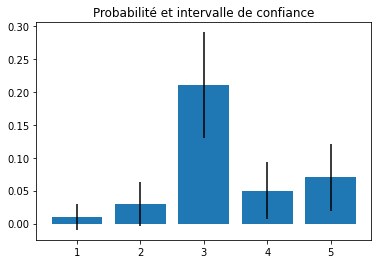

In [ ]:
#calcul des epsilon 
def intervalles(perc_vides, iter=100):  
  epsilons=[]
  for j in range(5):
    sigma2 = iter*(perc_vides[j]-perc_vides[j]**2)/(iter-1)
    eps=1.96*np.sqrt(sigma2)/np.sqrt(iter)  # 1.96 pour un intervalle de confiance à 95%
    epsilons.append(eps)
  return epsilons

epsilons = intervalles(perc_vides)

print("Pour la station 3, l'intervalle de confiance est : {}".format([perc_vides[0]-epsilons[0],perc_vides[0]+epsilons[0]]))
print("Pour la station 4, l'intervalle de confiance est : {}".format([perc_vides[1]-epsilons[1],perc_vides[1]+epsilons[1]]))
print("Pour la station 5, l'intervalle de confiance est : {}".format([perc_vides[2]-epsilons[2],perc_vides[2]+epsilons[2]]))
print("Pour la station 6, l'intervalle de confiance est : {}".format([perc_vides[3]-epsilons[3],perc_vides[3]+epsilons[3]]))
print("Pour la station 7, l'intervalle de confiance est : {}".format([perc_vides[4]-epsilons[4],perc_vides[4]+epsilons[4]]))

index = ["1", "2", "3", "4", "5"]
plt.bar(index, perc_vides, yerr=epsilons)
plt.title("Probabilité et intervalle de confiance")
plt.show()

## Calcul théorique

**6. En partant des équations de traffic vues en cours :** 

$$
\left\{
    \begin{array}{ll}
        \sum^J_{j=1} \alpha_j = 1 \\ 
        \forall j \leq J, \alpha_j \sum^J_{k=1} \lambda_{jk}= \sum^J_{k=1} \alpha_k \lambda_{jk}
    \end{array}
\right.
$$

Celles-ci deviennent, adaptées à notre modèle de vélos (ne considérant seulement les trajets d'une station vers une colonie entre deux stations, et inversement) et en ne considérant que 5 stations ($J=5$) :

$$ \sum^5_{i=1}\sum^5_{j=1}\, \alpha_{t_{ij}} ~ \text{avec} ~ \alpha_{t_{ii}}= \alpha_{ii} $$

et, $\forall i \leq 5$ : 

$$
\left\{
    \begin{array}{ll}
        \alpha_i\sum^5_{j=1,j \ne j} \lambda_{i,t_{ij}}= \sum^5_{j=1,j \ne j} \alpha_{t_{ij}} \lambda_{t_{ji},i} ~ (*) \\ 
        \forall j \ne i, \alpha_{t_{ij}}\lambda_{t_{ij},j}= \alpha_i \lambda_{i,t_{ij}}
    \end{array}
\right.
$$

On obtient, à partir de cette dernière équation : $ \forall j \ne i, \alpha_{t_ij} = \alpha_i \frac{\lambda_{i,t_{ij}}}{\lambda_{t_{ij},j}} $. En intégrant ce résultat dans le membre de droite de l'équation $(*)$, on obtient la relation : 

$ (*) \Rightarrow \forall i \leq 5, \alpha_i \sum^5_{j=1, j \ne i} \lambda_{i, t_{ij}} = \sum^5_{j=1, j \ne i} \alpha_j \lambda_{j,t_{ji}}$

$ \Leftrightarrow \forall i \leq 5, \alpha_i \sum^5_{j=1, j \ne i} \lambda_{i, t_{ij}} - \sum^5_{j=1, j \ne i} \alpha_j \lambda_{j,t_{ji}} = 0 $



**7. On considère désormais qu'il n'y a qu'un seul vélo.**

Dans le cas où il n'y a qu'un seul vélo, l'espace des états correspond au nombre d'états possibles et la somme doit valoir 1. Elle a une taille correspondant au carré du nombre de stations, ici $5$.

La taille de l'espace d'état est donc $25$ et les états correspondent aux vecteurs de la base canonique.

**8. Calculons la probabilité que chaque station soit vide, en considérant qu'il n'y a qu'un seul vélo.**

On utilise la formule donnée par le cours sur les colonies : 

$\pi(n) = G_N^{-1} \prod_{j=1}^J \frac{\alpha_j^{n_j}}{\prod_{r=1}^{n_j}\phi_j(r)}$ avec $n \in S$ soit $n$ est un vecteur de la base canonique de la forme $(0,0,...,1,...,0)$.

Si on note $e_k$ l'état où le 1 se trouve à la k-ème position, on a : 

$\pi(e_k) = G_N^{-1} \frac{\alpha_j}{\phi_j(1)} = G_N^{-1} \alpha_j$

En effet, les autres termes du produits seront tous égaux à 1 car les $n_j$ vaudront 0.

On a ensuite : $P(n_k = 0) = 1 - P(n_k = 1) = 1 - G_N^{-1} \alpha_j$

Avec $G_N$ la constante de normalisation soit $G_N = \sum_{j=1}^J \alpha_j = 1$

Calculons les probabilités théoriques :

**9. Comparaison aux résultats obtenus par simulation :**

On souhaite résoudre le système matriciel $M\alpha = X$, avec $\alpha$ le vecteur colonne $\alpha = \begin{pmatrix}
\alpha_{11} \\
\alpha_{12} \\
\vdots\\
\alpha_{21} \\
\alpha_{22} \\
\vdots \\
\alpha_{55}
 \end{pmatrix} $. 

Concernant la matrice $M$, on a pour les $24$ premières lignes : 
$$  m_{ii} = 
\left\{
    \begin{array}{ll}
        \sum^5_{k=1} \lambda_{(i//5)} t_{(i//5), k}  ~  ~ \text{si} ~  ~  i\equiv0[6] \\ 
        1  ~  ~  \text{sinon}
    \end{array}
\right.
$$

$$  m_{ij} = 
\left\{
    \begin{array}{ll}
       - \lambda_{(j//5),t_{(j//5),(i//5)}}  ~  ~ \text{si} ~  ~  i \ne j,  ~ i\equiv0[6] , ~  j\equiv0[6]\\ 
        \frac{\lambda_{(i//5),t_{(i//5)(i\%5)}}}{\lambda_{t_{(i//5)(i\%5)},(i\%5)}}  ~  ~  \text{si}  ~  ~ i\not\equiv0[6] , ~   j = i //5*6
    \end{array}
\right.
$$

$m_{ij} = 0 \text{ sinon}$

La dernière ligne de $M$ est égale à : $ \begin{pmatrix}
1 & 1 &  \dots & 1
 \end{pmatrix} $.

 Enfin, le X est un vecteur colonne égal à : 

$X = \begin{pmatrix}
0 \\
0 \\
\vdots\\
0 \\
1
 \end{pmatrix} $. 

In [ ]:
# Calcul de la matrice M

M = np.zeros((25,25))
X = np.zeros(25)
X[24]=1
for i in range(25):
    for j in range(25):
        if i==j:
            if i%6==0:
                M[i,i]=lambda_st[i//5].sum()
            else : 
                M[i,i]=1
                
        else:
            if i%6==0:
                if j%6==0:
                    M[i,j] = -lambda_st[j//5, i//5]
            else:
                if i//5*6==j:
                    M[i,j] = -lambda_st[i//5,i%5]/lambda_ts[i//5,i%5]
M[24]=1

In [ ]:
pd.DataFrame(M)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0.000778,0.0,0.0,0.0,0.0,0.0,-0.000175,0.0,0.0,0.0,0.0,0.0,-0.000290,0.0,0.0,0.0,0.0,0.0,-0.000165,0.0,0.0,0.0,0.0,0.0,-0.000230
1,-0.030800,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
2,-0.074667,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
3,-0.065333,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
4,-0.084933,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
5,0.000000,0.0,0.0,0.0,0.0,1.0,-0.020967,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
6,-0.000171,0.0,0.0,0.0,0.0,0.0,0.001028,0.0,0.0,0.0,0.0,0.0,-0.000397,0.0,0.0,0.0,0.0,0.0,-0.000214,0.0,0.0,0.0,0.0,0.0,-0.000307
7,0.000000,0.0,0.0,0.0,0.0,0.0,-0.041933,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
8,0.000000,0.0,0.0,0.0,0.0,0.0,-0.064750,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
9,0.000000,0.0,0.0,0.0,0.0,0.0,-0.086333,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000


In [ ]:
# calcul des proba 
alpha = np.dot(np.linalg.inv(M), X)
Gn = np.sum(alpha)
proba = (1-alpha/Gn)
proba_global = proba.reshape((5,5))
proba_station = np.diag(proba_global)
proba_trajets = proba_global - np.diag(proba_station)

print("Proba d'avoir des stations vides :", proba_station)
print("\nProba d'avoir des trajets tij vides :\n", proba_trajets)

Proba d'avoir des stations vides : [0.83217043 0.83885467 0.85801393 0.83851615 0.85011589]

Proba d'avoir des trajets tij vides :
 [[0.         0.99483085 0.98746873 0.98903513 0.98574568]
 [0.99662132 0.         0.99324264 0.98956584 0.98608779]
 [0.9901083  0.993232   0.         0.99062892 0.98789569]
 [0.98718895 0.98756574 0.98756574 0.         0.99472486]
 [0.98552119 0.98069493 0.97989055 0.99471409 0.        ]]


In [ ]:
Gn

0.9999999999999999

On retrouve bien $G_N = 1$. Testons avec la simulation :


Probas pour 1 vélo : [0.96 0.99 0.94 0.92 0.95]

Pour la station 3, l'intervalle de confiance est : [0.9213985084288813, 0.9986014915711187]
Pour la station 4, l'intervalle de confiance est : [0.9703999999999999, 1.0096]
Pour la station 5, l'intervalle de confiance est : [0.8932180817111153, 0.9867819182888846]
Pour la station 6, l'intervalle de confiance est : [0.866558654828519, 0.9734413451714811]
Pour la station 7, l'intervalle de confiance est : [0.9070675889427122, 0.9929324110572877]


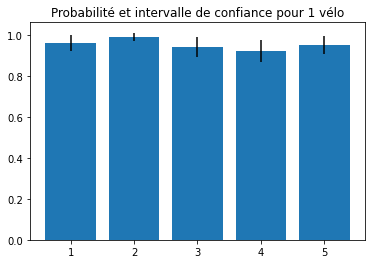

In [ ]:
# simulation 
deadline0 = 150*60*60
n_stations0 = np.array([1,0,0,0,0])
n_trajets0 = np.zeros((5,5))
perc_vides0 = perc_vide(deadline0,n_stations0,n_trajets0,lambda_st,lambda_ts, iter=100)
print("Probas pour 1 vélo :", perc_vides0)
epsilons0 = intervalles(perc_vides0)
print("\nPour la station 3, l'intervalle de confiance est : {}".format([perc_vides0[0]-epsilons0[0],perc_vides0[0]+epsilons0[0]]))
print("Pour la station 4, l'intervalle de confiance est : {}".format([perc_vides0[1]-epsilons0[1],perc_vides0[1]+epsilons0[1]]))
print("Pour la station 5, l'intervalle de confiance est : {}".format([perc_vides0[2]-epsilons0[2],perc_vides0[2]+epsilons0[2]]))
print("Pour la station 6, l'intervalle de confiance est : {}".format([perc_vides0[3]-epsilons0[3],perc_vides0[3]+epsilons0[3]]))
print("Pour la station 7, l'intervalle de confiance est : {}".format([perc_vides0[4]-epsilons0[4],perc_vides0[4]+epsilons0[4]]))


plt.bar(index, perc_vides0, yerr=epsilons0)
plt.title("Probabilité et intervalle de confiance pour 1 vélo")
plt.show()

C'est étrange car les valeurs théoriques sont pas comprises dans les intervalles de confiances ...

## Simulation pour 100 vélos : 

**10. On simule le même réseau, cette fois-ci avec les vélos répartis de façon uniforme entre les stations et les routes.**

On doit tout d'abord changer nos conditions initiales par rapport à la première simulation, de manière à avoir le même nombre de vélo dans chaque station et route.

In [ ]:
n_stations1 = np.array([4,4,4,4,4])

n_trajets1 = np.array([[0, 4, 4, 4, 4],
                      [4, 0, 4, 4, 4], 
                      [4, 4, 0, 4, 4], 
                      [4, 4, 4, 0, 4], 
                      [4, 4, 4, 4, 4]])

[[27  0  0  0  0]
 [ 0 18  0  0  0]
 [ 0  0 14  0  0]
 [ 0  0  0 20  0]
 [ 0  1  0  1 10]]


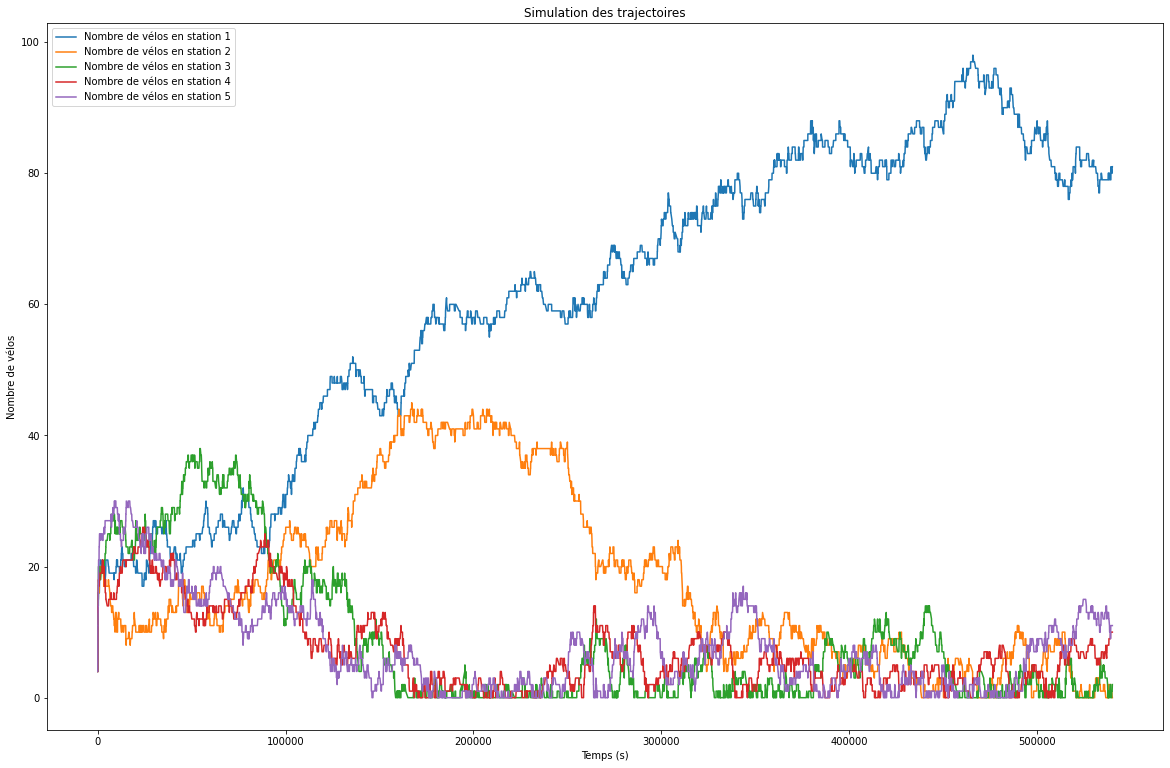

In [ ]:
E1,times1,nb_station1 = simulation(150*60*60,n_stations1,n_trajets1,lambda_st,lambda_ts)
print(E)
trace(times1,nb_station1)

Ici la station 1 semble avoir une probabilité d'être vide inférieure à celles des autres stations

11. Calculons la probabilité stationnaire que chaque station soit vide.

